# Исследование по выбору OLAP хранилища

### Список хранилищ для сравнения

* Spark
* Clickhouse
* Vertica

Описание структуры приведено в docker-compose.yml (каждое хранилище представлено одной нодой).

### Порядок работы

1. Подготовка тестовых данных для загрузки в хранилище. Размер выборки - 1М;
2. Тестирование обработки загрузки и чтения загруженных данных.
3. Тестирование обработки чтения данных при параллельном добавлении данных в базу.

### Окружение

In [2]:
!python3 --version && python3 -m pip list

Python 3.6.9
Package                           Version
--------------------------------- ---------------
argon2-cffi                       20.1.0
asn1crypto                        0.24.0
async-generator                   1.10
attrs                             21.2.0
backcall                          0.2.0
backports.entry-points-selectable 1.1.0
backports.zoneinfo                0.2.1
beautifulsoup4                    4.6.0
bleach                            3.3.1
certifi                           2021.5.30
cffi                              1.14.6
chardet                           3.0.4
charset-normalizer                2.0.3
clickhouse-driver                 0.2.5
cloudpickle                       1.6.0
cryptography                      2.1.4
cycler                            0.10.0
dataclasses                       0.8
decorator                         4.4.2
defusedxml                        0.7.1
distlib                           0.3.2
entrypoints                       0.3
filelock   

## Генерация данных

In [11]:
import csv
from csv import reader
import random
import time
import pickle
from uuid import uuid4

import numpy as np
import pandas as pd
import scipy.stats as st
from tqdm import tqdm

In [3]:
BATCH_SIZE = 1000 # размер батча для вставки
BATCH_NUMBER = 1000 # количетсво батчей
USERS_NUMBER = 1000 # количество уникальных пользователей
MOVIES_NUMBER = 1000 # количество уникальных фильмов
ITERATIONS = 10 # количество итераций для замера времени выполнения запроса к хранилищу
BATCH_SIZE_LOAD = 100 # количество записей при вставке под нагрузкой
DELAY_LOAD = 0.001 # время задержки между запросами при тестировании под нагрузкой

In [88]:
users_id = [str(uuid4()) for _ in range(USERS_NUMBER)]
movies_id = [str(uuid4()) for _ in range(MOVIES_NUMBER)]

with open('data.csv', 'w', newline='') as csvfile:
    fieldnames = ['user_id', 'movie_id', 'progress']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for i in tqdm(range(BATCH_NUMBER)):
        for j in range(BATCH_SIZE):
            writer.writerow(
                {
                    'user_id': random.choice(users_id),
                    'movie_id': random.choice(movies_id),
                    'progress': int(i / BATCH_NUMBER * random.uniform(60*60*1.8, 60*60*2.2))
                }
            )

100%|██████████| 1000/1000 [00:05<00:00, 181.72it/s]


## Загрузка данных в хранилища и тестирование

Замеры времени работы производятся:
1. Для вставки данных (insert_data);
2. Для запросов по получению:
    * среднего времени для всех фильмов (select_average_progresses);
    * всех последних данных по просмотрам фильмов для конкретного пользователя (select_max_progresses_by_user);
    * списка всех фильмов для конкретного пользователя (select_movies_by_user);
    * списка пользователей, кто смотрел/смотрит конкретный фильм (select_users_by_movie).

In [89]:
tests = {
    "insert_data": None,
    "select_average_progresses": None,
    "select_max_progresses_by_user": None,
    "select_movies_by_user": None,
    "select_users_by_movie": None,
    "select_average_progresses_under_load": None,
    "select_max_progresses_by_user_under_load": None,
    "select_movies_by_user_under_load": None,
    "select_users_by_movie_under_load": None,
}

time_result = {
    "spark": dict(tests),
    "clickhouse": dict(tests),
    "vertica": dict(tests),
    "base": {"user_id": None, "movie_id": None}
}
save_time_measurement()

In [4]:
def save_time_measurement():
    global time_result
    
    with open('time_result.pickle', 'wb') as file:
        pickle.dump(time_result, file)

def get_time_measurement():
    try:
        global time_result

        if time_result and not time_result["spark"]["select_average_progresses"]:
            with open('time_result.pickle', 'rb') as f:
                time_result = pickle.load(f)
    except NameError:
        with open('time_result.pickle', 'rb') as f:
            time_result = pickle.load(f)
    return time_result

## <center>Исследования Apache Spark</center>

In [82]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import col

**Установим соединение**

In [83]:
conf = pyspark.SparkConf()
conf.setMaster('spark://spark-master:7077')
spark_context = pyspark.SparkContext(conf=conf)

**Протестируем запросы по получению данных**

In [91]:
spark = SparkSession.builder.master('spark://spark-master:7077') \
          .appName("SparkReasearch") \
          .getOrCreate()

In [92]:
df = spark.read.csv('data.csv', sep=',', inferSchema=True, header=True)
df.show()

+--------------------+--------------------+--------+
|             user_id|            movie_id|progress|
+--------------------+--------------------+--------+
|31e4da92-4311-494...|f6aef32e-5d71-43c...|       0|
|b0b50958-6883-434...|01d8cfe9-6149-4d0...|       0|
|c09a3a37-4c73-4ea...|f163d612-93b1-4dd...|       0|
|3ea24eff-042d-4e5...|92012d2b-2029-40f...|       0|
|ee81fe59-3e11-43e...|b9e5e55d-d3e2-44e...|       0|
|9c177422-f401-460...|45ea26e2-36b5-413...|       0|
|9f00c84c-58c6-484...|05147908-90ce-440...|       0|
|91b3b4f4-27a0-450...|5be0ef4d-2fde-4b4...|       0|
|66578be3-255a-44a...|ac0338a6-d2f4-422...|       0|
|4f0f0d95-706a-489...|b958319d-ec11-41d...|       0|
|1adc995d-e4f7-4bb...|2d3fa09f-8899-45e...|       0|
|16e856ec-d0e7-4cc...|78b00e7c-910a-4e0...|       0|
|7638bfc7-ad3b-430...|7453f612-b16d-45a...|       0|
|c3c38778-8c78-409...|60d3614a-0ce1-40c...|       0|
|ab450fa5-c481-468...|00471c88-e59d-4b7...|       0|
|8ad82fc1-c400-405...|3c539e96-1340-49e...|   

**select average progresses**

In [93]:
times = []
for i in tqdm(range(ITERATIONS)):
    s_t = time.time()
    result = df.groupBy('movie_id').agg(f.avg('progress'))
    _ = result.collect()
    e_t = time.time()
    times.append(e_t - s_t)
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["spark"]["select_average_progresses"] = borders[1]
print("Count rows - {}".format(len(_)))
print("[Spark] Time select average progresses - {:.4f} sec".format(np.mean(times)))
result_pd = result.toPandas()
result_pd.head()

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Count rows - 1000
[Spark] Time select average progresses - 1.0669 sec


,movie_id,avg(progress)
0,a8c5c7a5-a27c-4831-bab9-90775bb209ae,3690.175153
1,e1a09fc4-b0bc-4c31-b308-6a218a781048,3539.524590
2,6aacaa27-060d-4d83-bacc-6c237d13697a,3636.183976
3,f7006096-495c-4ba1-ba89-f4d12bdf0f81,3587.597526
4,63f7397b-d02c-40d4-b396-95c4f84d6802,3654.370443


**select_max_progresses_by_user**

In [94]:
user_id = df.first()['user_id']
times = []
for i in tqdm(range(ITERATIONS)):
    s_t = time.time()
    result = df.filter(col("user_id") == user_id).groupBy('movie_id').agg(f.max('progress'))
    _ = result.collect()
    e_t = time.time()
    times.append(e_t - s_t)
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["spark"]["select_max_progresses_by_user"] = borders[1]
print("User_id - {}".format(user_id))
print("Count rows - {}".format(len(_)))
print("[Spark] Time select max progresses by user - {:.4f} sec".format(np.mean(times)))
result_pd = result.toPandas()
result_pd.head()

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


User_id - 31e4da92-4311-494f-9691-640e478bb5ef
Count rows - 621
[Spark] Time select max progresses by user - 0.8934 sec


,movie_id,max(progress)
0,a8c5c7a5-a27c-4831-bab9-90775bb209ae,6307
1,6aacaa27-060d-4d83-bacc-6c237d13697a,3767
2,f7006096-495c-4ba1-ba89-f4d12bdf0f81,6256
3,63f7397b-d02c-40d4-b396-95c4f84d6802,132
4,29b54f1b-cda2-4ef4-bd37-ce9679097357,1832


**select_movies_by_user**

In [95]:
user_id = df.first()['user_id']
times = []
for i in tqdm(range(ITERATIONS)):
    s_t = time.time()
    result = df.filter(col("user_id") == user_id).dropDuplicates(["movie_id"]).select("movie_id")
    _ = result.collect()
    e_t = time.time()
    times.append(e_t - s_t)
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["spark"]["select_movies_by_user"] = borders[1]
print("User_id - {}".format(user_id))
print("Count rows - {}".format(len(_)))
print("[Spark] Time select movies by user - {:.4f} sec".format(np.mean(times)))
result_pd = result.toPandas()
result_pd.head()

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


User_id - 31e4da92-4311-494f-9691-640e478bb5ef
Count rows - 621
[Spark] Time select movies by user - 0.7788 sec


,movie_id
0,a8c5c7a5-a27c-4831-bab9-90775bb209ae
1,6aacaa27-060d-4d83-bacc-6c237d13697a
2,f7006096-495c-4ba1-ba89-f4d12bdf0f81
3,63f7397b-d02c-40d4-b396-95c4f84d6802
4,29b54f1b-cda2-4ef4-bd37-ce9679097357


**select_users_by_movie**

In [96]:
movie_id = df.first()['movie_id']
times = []
for i in tqdm(range(ITERATIONS)):
    s_t = time.time()
    result = df.filter(col("movie_id") == movie_id).dropDuplicates(["user_id"]).select("user_id")
    _ = result.collect()
    e_t = time.time()
    times.append(e_t - s_t)
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["spark"]["select_users_by_movie"] = borders[1]
print("Movie_id - {}".format(movie_id))
print("Count rows - {}".format(len(_)))
print("[Spark] Time select movies by user - {:.4f} sec".format(np.mean(times)))
result_pd = result.toPandas()
result_pd.head()

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Movie_id - f6aef32e-5d71-43c0-b667-45d2f4aa060a
Count rows - 642
[Spark] Time select movies by user - 0.7960 sec


,user_id
0,a68f68e5-c11c-4ace-a75b-2178a0db1729
1,268073bd-25d0-4d0b-91df-7f7f206c9a75
2,a7705cbc-5936-401a-a6f9-366e8b324e06
3,2aac51c7-7a6c-48e3-920d-f9df30db7d86
4,6c2e52c8-89d1-46fb-b7d3-bfbe65e72c92


Замеры времени по агрегационным запросам (95% нижняя граница доверительного интервала)

In [98]:
save_time_measurement()
time_result = get_time_measurement()

In [99]:
time_result["spark"]

{'insert_data': None,
 'select_average_progresses': 1.1017745312808997,
 'select_max_progresses_by_user': 0.9422370550750439,
 'select_movies_by_user': 0.8188158323112225,
 'select_users_by_movie': 0.8221653214039026,
 'select_average_progresses_under_load': None,
 'select_max_progresses_by_user_under_load': None,
 'select_movies_by_user_under_load': None,
 'select_users_by_movie_under_load': None}

In [100]:
time_result["base"]["user_id"] = user_id
time_result["base"]["movie_id"] = movie_id
save_time_measurement()

In [101]:
del df
del result
del result_pd

## <center>Исследования Clickhouse</center>

In [2]:
from clickhouse_driver import Client

Инициализируем клиента

In [3]:
clickhouse_client = Client(host='clickhouse')

Создадим базу для тестирования времени записи

In [104]:
clickhouse_client.execute("CREATE DATABASE IF NOT EXISTS test")

[]

Посмотрим существующие базы

In [105]:
clickhouse_client.execute('SHOW DATABASES')

[('_temporary_and_external_tables',), ('default',), ('system',), ('test',)]

In [4]:
QUERIES = {
    "create": """
        CREATE TABLE IF NOT EXISTS {}.views (
        id String,
        user_id String,
        movie_id String,
        progress Int64
        )  Engine=MergeTree() ORDER BY (user_id, movie_id)
    """,
    "insert": """
        INSERT INTO {}.views (user_id, movie_id, progress) VALUES
    """,
    "delete": """
        ALTER TABLE {}.views DELETE WHERE user_id IS NOT NULL
    """,
    "count": """
        SELECT COUNT(*) FROM {}.views
    """,
    "select": """
        SELECT * FROM {}.views LIMIT {}
    """,
    "select_average_progresses": """
        SELECT movie_id, AVG(progress)
        FROM {}.views
        GROUP BY movie_id
    """,
    "select_max_progresses_by_user": """
        SELECT movie_id, max(progress)
        FROM {}.views
        WHERE user_id = %(user_id)s
        GROUP BY movie_id
    """,
    "select_movies_by_user": """
        SELECT DISTINCT (movie_id)
        FROM {}.views
        WHERE user_id = %(user_id)s
    """,
    "select_users_by_movie": """
        SELECT DISTINCT (user_id) FROM {}.views WHERE movie_id = %(movie_id)s
    """,
}

Создадим таблицу для тестирования запросов чтения

In [110]:
query = QUERIES["create"]
clickhouse_client.execute(query.format('default'))
clickhouse_client.execute(query.format('test'))

[]

Посмотрим существующие таблицы

In [111]:
print(clickhouse_client.execute('SHOW TABLES FROM default;'))
print(clickhouse_client.execute('SHOW TABLES FROM test;'))

[('views',)]
[('views',)]


Опишем список запросов по которым будут производится замеры времени отработки

**insert_data**

In [112]:
times = []
database = 'test'
for iteration in tqdm(range(ITERATIONS)):
    values = []
    with open('data.csv', 'r') as file:
        csv_reader = reader(file)
        header = next(csv_reader)
        for idx, row in enumerate(csv_reader):
            if idx == BATCH_SIZE:
                break
            values.append([row[0], row[1], int(row[2])])
    s_t = time.time()
    clickhouse_client.execute(QUERIES["insert"].format(database), values)
    e_t = time.time()
    times.append(e_t - s_t)        
    clickhouse_client.execute(QUERIES["delete"].format(database))
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["insert_data"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 81.32it/s]


**Для замеров скорости выполнения агрегационных запросов, загрузим ранее сгенерированные данные в Clickhouse**

In [13]:
%%time
database = 'default'
values = []
with open('data.csv', 'r') as file:
    csv_reader = reader(file)
    header = next(csv_reader)
    for idx, row in enumerate(csv_reader):
        values.append([row[0], row[1], int(row[2])])
        if len(values) >= BATCH_SIZE:
            clickhouse_client.execute(QUERIES["insert"].format(database), values)
            values = []
if values:
    clickhouse_client.execute(QUERIES["insert"].format(database), values)
    del values

CPU times: user 2.23 s, sys: 207 ms, total: 2.44 s
Wall time: 3.85 s


In [14]:
clickhouse_client.execute(QUERIES["select"].format(database, 5))

[('',
  '00169d0b-c16b-4fff-83d5-352ffe268428',
  '00fb0891-2478-44e9-b3da-eb9711e6f0f0',
  605),
 ('',
  '00169d0b-c16b-4fff-83d5-352ffe268428',
  '0201c59b-5a22-48f7-928e-94ae4aa94408',
  735),
 ('',
  '00169d0b-c16b-4fff-83d5-352ffe268428',
  '0270b935-df22-49f0-9f8e-1172c36284b8',
  795),
 ('',
  '00169d0b-c16b-4fff-83d5-352ffe268428',
  '028b55b3-0846-40b2-966f-a85fdd32babe',
  80),
 ('',
  '00169d0b-c16b-4fff-83d5-352ffe268428',
  '02d1fe16-00ed-4869-8aff-079d85738019',
  284)]

Проверим количество записей в хранилище

In [15]:
database = 'default'
clickhouse_client.execute(QUERIES["count"].format(database))

[(1000000,)]

**select average progresses**

In [117]:
times = []
database = 'default'
for iteration in tqdm(range(ITERATIONS)):
    s_t = time.time()
    clickhouse_client.execute(QUERIES["select_average_progresses"].format(database))
    e_t = time.time()
    times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["select_average_progresses"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 48.05it/s]


**select_max_progresses_by_user**

In [118]:
user_id = user_id or time_result["base"]["user_id"]
times = []
database = 'default'
for iteration in tqdm(range(ITERATIONS)):
    s_t = time.time()
    _ = clickhouse_client.execute(
        QUERIES["select_max_progresses_by_user"].format(database),
        {"user_id": user_id}
    )
    e_t = time.time()
    times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["select_max_progresses_by_user"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 225.99it/s]


**select_movies_by_user**

In [119]:
user_id = user_id or time_result["base"]["user_id"]
times = []
database = 'default'
for iteration in tqdm(range(ITERATIONS)):
    s_t = time.time()
    _ = clickhouse_client.execute(
        QUERIES["select_movies_by_user"].format(database),
        {"user_id": user_id}
    )
    e_t = time.time()
    times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["select_movies_by_user"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 286.82it/s]


**select_users_by_movie**

In [120]:
movie_id = movie_id or time_result["base"]["movie_id"]
times = []
database = 'default'
for iteration in tqdm(range(ITERATIONS)):
    s_t = time.time()
    _ = clickhouse_client.execute(
        QUERIES["select_users_by_movie"].format(database),
        {"movie_id": movie_id}
    )
    e_t = time.time()
    times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["select_users_by_movie"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 44.72it/s]


**Замеры ранее указанных запросов под нагрузкой порядка 1000 RPS**

In [121]:
import asyncio

BATCH_SIZE_LOAD = 100
DELAY_LOAD = 0.001

QUERY = "INSERT INTO default.views (user_id, movie_id, progress) VALUES"

async def update():
    while True:
        values = [
            {
                "user_id": random.choice(str(uuid4())),
                "movie_id": random.choice(str(uuid4())),
                "progress": random.randint(0, 60*60*2),
            }
            for _ in range(BATCH_SIZE_LOAD)
        ]
        clickhouse_client.execute(QUERY, values)
        await asyncio.sleep(DELAY_LOAD)


loop = asyncio.get_event_loop()
loop.create_task(update());

In [122]:
# select average progresses
times = []
database = 'default'
for iteration in tqdm(range(ITERATIONS)):
    s_t = time.time()
    clickhouse_client.execute(QUERIES["select_average_progresses"].format(database))
    e_t = time.time()
    times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["select_average_progresses_under_load"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()
# select_max_progresses_by_user
user_id = user_id or time_result["base"]["user_id"]
times = []
database = 'default'
for iteration in tqdm(range(ITERATIONS)):
    s_t = time.time()
    _ = clickhouse_client.execute(
        QUERIES["select_max_progresses_by_user"].format(database),
        {"user_id": user_id}
    )
    e_t = time.time()
    times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["select_max_progresses_by_user_under_load"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()
# select_movies_by_user
user_id = user_id or time_result["base"]["user_id"]
times = []
database = 'default'
for iteration in tqdm(range(ITERATIONS)):
    s_t = time.time()
    _ = clickhouse_client.execute(
        QUERIES["select_movies_by_user"].format(database),
        {"user_id": user_id}
    )
    e_t = time.time()
    times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["select_movies_by_user_under_load"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()
# select_users_by_movie
movie_id = movie_id or time_result["base"]["movie_id"]
times = []
database = 'default'
for iteration in tqdm(range(ITERATIONS)):
    s_t = time.time()
    _ = clickhouse_client.execute(
        QUERIES["select_users_by_movie"].format(database),
        {"movie_id": movie_id}
    )
    e_t = time.time()
    times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["clickhouse"]["select_users_by_movie_under_load"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 45.76it/s]


In [123]:
loop.stop()

**Посмотрим количество добавленных записей в процессе тестирования времени генерации ответов под нагрузкой**

In [10]:
clickhouse_client.execute(QUERIES["count"].format('default'))

[(1227200,)]

In [17]:
time_result = get_time_measurement()

Замеры времени по агрегационным запросам (95% нижняя граница доверительного интервала)

In [18]:
time_result["clickhouse"]

{'insert_data': 0.006920485758143514,
 'select_average_progresses': 0.023395688345616682,
 'select_max_progresses_by_user': 0.0057029482221316935,
 'select_movies_by_user': 0.004123628970761127,
 'select_users_by_movie': 0.02385726814930142,
 'select_average_progresses_under_load': 0.023256511216343256,
 'select_max_progresses_by_user_under_load': 0.0031631070324024155,
 'select_movies_by_user_under_load': 0.002926766152475889,
 'select_users_by_movie_under_load': 0.023804838208832522}

## <center>Исследования Vertica</center>

In [19]:
connection_info = {
    "host": "vertica",
    "port": 5433,
    "user": "dbadmin",
    "password": "",
    "database": "docker",
    "autocommit": True,
} 

In [25]:
QUERIES = {
    "create_schema": """
       CREATE SCHEMA IF NOT EXISTS {};
    """,
    "create": """
        CREATE TABLE IF NOT EXISTS {}.views (
            user_id VARCHAR(50) NOT NULL,
            movie_id VARCHAR(50) NOT NULL,
            progress INTEGER NOT NULL
        ) ORDER BY user_id, movie_id;
    """,
    "insert": """
        INSERT INTO {}.views (user_id, movie_id, progress) VALUES (?, ?, ?)
    """,
    "drop": """
        DROP TABLE IF EXISTS {}.views;
    """,
    "delete": """
        DELETE FROM {}.views;
    """,
    "count": """
        SELECT COUNT(*) FROM {}.views
    """,
    "select": """
        SELECT * FROM {}.views LIMIT {}
    """,
    "select_average_progresses": """
        SELECT movie_id, AVG(progress)
        FROM {}.views
        GROUP BY movie_id
    """,
    "select_max_progresses_by_user": """
        SELECT movie_id, max(progress)
        FROM {}.views
        WHERE user_id = :user_id
        GROUP BY movie_id
    """,
    "select_movies_by_user": """
        SELECT DISTINCT (movie_id)
        FROM {}.views
        WHERE user_id = :user_id
    """,
    "select_users_by_movie": """
        SELECT DISTINCT (user_id) FROM {}.views WHERE movie_id = :movie_id
    """,
}

In [21]:
import vertica_python

schemas = ["test", "base"]

for schema in schemas:
    with vertica_python.connect(**connection_info) as connection:
        cursor = connection.cursor()
        cursor.execute(QUERIES["drop"].format(schema))

In [22]:
import vertica_python

schema = "test"

with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    cursor.execute(QUERIES["create_schema"].format(schema))
    cursor.execute(QUERIES["create"].format(schema)) 

In [23]:
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    cursor.execute("SELECT DISTINCT table_name, table_type FROM all_tables WHERE table_name = 'views'")
    res = cursor.fetchall()
res

[['views', 'TABLE'], ['views', 'SYSTEM TABLE']]

**insert_data**

In [27]:
times = []
schema = "test"
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        values = []
        with open("data.csv", "r") as file:
            csv_reader = reader(file)
            header = next(csv_reader)
            for idx, row in enumerate(csv_reader):
                if idx == BATCH_SIZE:
                    break
                values.append([row[0], row[1], int(row[2])])
        s_t = time.time()
        cursor.executemany(QUERIES["insert"].format(schema), values, use_prepared_statements=True)
        e_t = time.time()
        times.append(e_t - s_t)        
        cursor.execute(QUERIES["delete"].format(schema))
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["insert_data"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:39<00:00,  4.00s/it]


**Для замеров скорости выполнения агрегационных запросов, загрузим ранее сгенерированные данные в Vertica**

In [29]:
%%time
shema = "test"
values = []
with open("data.csv", "r") as file, vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    csv_reader = reader(file)
    header = next(csv_reader)
    for idx, row in enumerate(csv_reader):
        values.append([row[0], row[1], int(row[2])])
        if len(values) >= BATCH_SIZE:
            cursor.executemany(QUERIES["insert"].format(shema), values, use_prepared_statements=True)
            values = []
    if values:
        cursor.executemany(QUERIES["insert"].format(shema), values, use_prepared_statements=True)
        del values

CPU times: user 43.8 s, sys: 1.95 s, total: 45.7 s
Wall time: 1h 8min 56s


Количество строк в таблице после вставки

In [30]:
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    cursor.execute(QUERIES["count"].format(schema))
    row = cursor.fetchall()
print(row)

[[1000000]]


**select average progresses**

In [32]:
times = []
schema = "test"
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        s_t = time.time()
        cursor.execute(QUERIES["select_average_progresses"].format(schema))
        cursor.fetchall()
        e_t = time.time()
        times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["select_average_progresses"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


**select_max_progresses_by_user**

In [34]:
user_id = time_result["base"]["user_id"]
times = []
schema = "test"
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        s_t = time.time()
        cursor.execute(QUERIES["select_max_progresses_by_user"].format(schema), {"user_id": user_id})
        cursor.fetchall()
        e_t = time.time()
        times.append(e_t - s_t)
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["select_max_progresses_by_user"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 44.44it/s]


**select_movies_by_user**

In [36]:
user_id = time_result["base"]["user_id"]
times = []
schema = "test"
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        s_t = time.time()
        cursor.execute(QUERIES["select_movies_by_user"].format(schema), {"user_id": user_id})
        cursor.fetchall()
        e_t = time.time()
        times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["select_movies_by_user"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 44.60it/s]


**select_users_by_movie**

In [38]:
movie_id = time_result["base"]["movie_id"]
times = []
schema = "test"
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        s_t = time.time()
        cursor.execute(QUERIES["select_users_by_movie"].format(schema), {"movie_id": movie_id})
        cursor.fetchall()
        e_t = time.time()
        times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["select_users_by_movie"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 27.68it/s]


**Замеры ранее указанных запросов под нагрузкой порядка 1000 RPS**

In [41]:
import asyncio

BATCH_SIZE_LOAD = 100
DELAY_LOAD = 0.001

QUERY = "INSERT INTO test.views (user_id, movie_id, progress) VALUES (?, ?, ?)"

async def update():
    with vertica_python.connect(**connection_info) as connection:
        cursor = connection.cursor()
        while True:
            values = [
                (
                    random.choice(str(uuid4())),
                    random.choice(str(uuid4())),
                    random.randint(0, 60*60*2),
                )
                for _ in range(BATCH_SIZE_LOAD)
            ]
            cursor.executemany(QUERY, values, use_prepared_statements=True)
            await asyncio.sleep(DELAY_LOAD)

loop = asyncio.get_event_loop()
loop.create_task(update());

In [42]:
# select average progresses
times = []
schema = "test"
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        s_t = time.time()
        cursor.execute(QUERIES["select_average_progresses"].format(schema))
        cursor.fetchall()
        e_t = time.time()
        times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["select_average_progresses_under_load"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()
# select_max_progresses_by_user
user_id = user_id or time_result["base"]["user_id"]
times = []
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        s_t = time.time()
        cursor.execute(QUERIES["select_max_progresses_by_user"].format(schema), {"user_id": user_id})
        cursor.fetchall()
        e_t = time.time()
        times.append(e_t - s_t)
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["select_max_progresses_by_user_under_load"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()
# select_movies_by_user
user_id = user_id or time_result["base"]["user_id"]
times = []
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        s_t = time.time()
        cursor.execute(QUERIES["select_movies_by_user"].format(schema), {"user_id": user_id})
        cursor.fetchall()
        e_t = time.time()
        times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["select_movies_by_user_under_load"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()
# select_users_by_movie
movie_id = movie_id or time_result["base"]["movie_id"]
times = []
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    for iteration in tqdm(range(ITERATIONS)):
        s_t = time.time()
        cursor.execute(QUERIES["select_users_by_movie"].format(schema), {"movie_id": movie_id})
        cursor.fetchall()
        e_t = time.time()
        times.append(e_t - s_t)        
borders = st.t.interval(alpha=0.95, df=len(times)-1, loc=np.mean(times), scale=st.sem(times))
time_result["vertica"]["select_users_by_movie_under_load"] = borders[1]
save_time_measurement()
time_result = get_time_measurement()

100%|██████████| 10/10 [00:00<00:00, 29.34it/s]


Остановим асинхронный процесс записи и переподключимся к kernel

In [43]:
loop.stop()

In [7]:
time_result = get_time_measurement()
time_result

{'spark': {'insert_data': None,
  'select_average_progresses': 1.1017745312808997,
  'select_max_progresses_by_user': 0.9422370550750439,
  'select_movies_by_user': 0.8188158323112225,
  'select_users_by_movie': 0.8221653214039026,
  'select_average_progresses_under_load': None,
  'select_max_progresses_by_user_under_load': None,
  'select_movies_by_user_under_load': None,
  'select_users_by_movie_under_load': None},
 'clickhouse': {'insert_data': 0.006920485758143514,
  'select_average_progresses': 0.023395688345616682,
  'select_max_progresses_by_user': 0.0057029482221316935,
  'select_movies_by_user': 0.004123628970761127,
  'select_users_by_movie': 0.02385726814930142,
  'select_average_progresses_under_load': 0.023256511216343256,
  'select_max_progresses_by_user_under_load': 0.0031631070324024155,
  'select_movies_by_user_under_load': 0.002926766152475889,
  'select_users_by_movie_under_load': 0.023804838208832522},
 'vertica': {'insert_data': 1.5422243078973354,
  'select_averag

# Результаты

Таблица затрачиваемого времени для вставки и чтения данных в рассматриваемые хранилища приведена ниже (значения верхней границы 95% доверительного интервала).

In [57]:
table = dict(time_result)
table.pop("base")
table = pd.DataFrame.from_dict(table)
table.columns = ["Spark, ms", "Clickhouse, ms", "Vertica, ms"]
table = table.iloc[:,:]*1000
table["Vertica / Clickhouse"] = table.iloc[:,-1] / table.iloc[:,-2]
table

,"Spark, ms","Clickhouse, ms","Vertica, ms",Vertica / Clickhouse
insert_data,NaN,6.920486,1542.224308,222.849141
select_average_progresses,1101.774531,23.395688,241.264718,10.312358
select_average_progresses_under_load,NaN,23.256511,200.237936,8.609973
select_max_progresses_by_user,942.237055,5.702948,29.064903,5.096470
select_max_progresses_by_user_under_load,NaN,3.163107,24.380828,7.707873
select_movies_by_user,818.815832,4.123629,23.966718,5.812045
select_movies_by_user_under_load,NaN,2.926766,21.878462,7.475302
select_users_by_movie,822.165321,23.857268,38.622136,1.618883
select_users_by_movie_under_load,NaN,23.804838,34.941022,1.467812


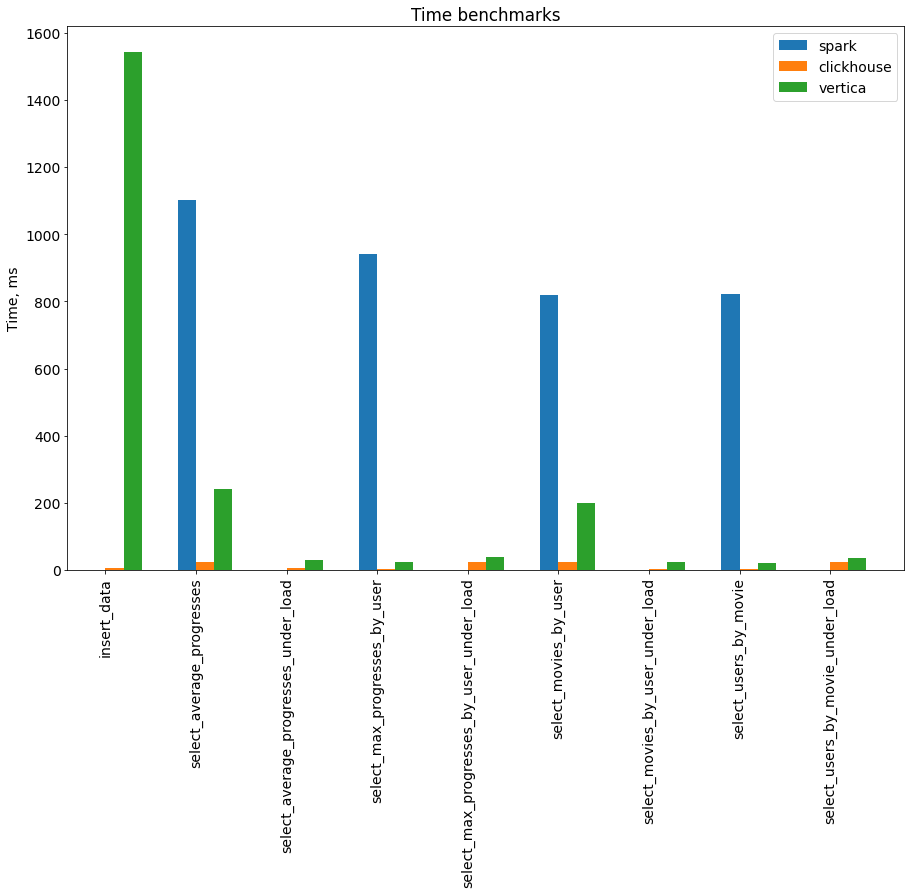

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})

labels = spark_df.index.values.tolist()
spark = [value*1000 if value else 0 for value in spark_df.iloc[:, 0].tolist()]
clickhouse = [value*1000 if value else 0 for value in clickhouse_df.iloc[:, 0].tolist()]
vertica = [value*1000 if value else 0 for value in vertica_df.iloc[:, 0].tolist()]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, spark, width, label='spark')
rects2 = ax.bar(x + width/2, clickhouse, width, label='clickhouse')
rects3 = ax.bar(x + 3*width/2, vertica, width, label='vertica')

ax.set_ylabel('Time, ms')
ax.set_title('Time benchmarks')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

plt.show()

По проведенным замерам видно, что OLAP хранилище Clickhouse существенно превосходит своих оппонентов, особенно по скорости вставки данных.

# Список исполнителей

* <a href='https://github.com/Oorzhakau'>Ооржак Александр Юрьевич</a>